In [1]:
# Load modules
from pyDOE2 import fullfact
import numpy as np
import pandas as pd

In [2]:
## Create initial design matrix
design = pd.DataFrame(fullfact([10,9,10,9]),columns=['bid1','dam1','bid2','dam2'])

In [3]:
# Keep only choice situations where alt 1 is the 'cheap and damaging' alt, and alt 2 is the 'expensive and corrective' alt
design = design[(design['bid1']<design['bid2']) & (design['dam1']>design['dam2'])]

# Replicate the design 50000 rows
design = design.sample(n=50000,replace=True,ignore_index=True)

In [4]:
# Replace values
design['bid1'] = design['bid1'].copy().replace({0:10,1:30,2:40,3:50,4:60,5:70,6:80,7:90,8:100,9:120})
design['bid2'] = design['bid2'].copy().replace({0:10,1:30,2:40,3:50,4:60,5:70,6:80,7:90,8:100,9:120})

design['dam1'] = (design['dam1'].copy() + 1 )*10
design['dam2'] = (design['dam2'].copy() + 1 )*10

In [5]:
bvtt = (- (design['bid2']-design['bid1']) / (design['dam2']-design['dam1'])).to_numpy()
design['bvtt'] = bvtt

In [6]:
# Sample the design
# design = design.sample(n=len(design),replace=False,ignore_index=True,random_state=12345)

In [7]:
# Set random generator
generator = np.random.default_rng(seed=12345)

In [8]:
# Set 'true' parameter values
mu = 2

vtt_1 = generator.normal(loc=2,scale=1,size=int(bvtt.shape[0]/10/2))
vtt_2 = generator.normal(loc=6,scale=1,size=int(bvtt.shape[0]/10/2))

vtt_1 = np.repeat(vtt_1,10)
vtt_2 = np.repeat(vtt_2,10)

e1_1 = generator.gumbel(size=int(bvtt.shape[0]/2))
e1_2 = generator.gumbel(size=int(bvtt.shape[0]/2))

e2_1 = generator.gumbel(size=int(bvtt.shape[0]/2))
e2_2 = generator.gumbel(size=int(bvtt.shape[0]/2))

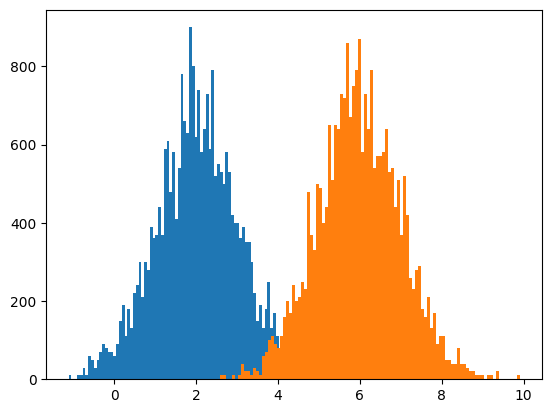

In [9]:
import matplotlib.pyplot as plt
plt.hist(vtt_1,bins=100)
plt.hist(vtt_2,bins=100)
plt.show()

In [10]:
# Calculate utilities and chosen alternative
V1_1 = mu * bvtt[:int(bvtt.shape[0]/2)]
V1_2 = mu * bvtt[int(bvtt.shape[0]/2):]

V2_1 = mu * vtt_1
V2_2 = mu * vtt_2

U1_1 = V1_1 + e1_1
U2_1 = V2_1 + e2_1


U1_2 = V1_2 + e1_2
U2_2 = V2_2 + e2_2

V1 = np.r_[V1_1,V1_2]
V2 = np.r_[V2_1,V2_2]

U1 = np.r_[U1_1,U1_2]
U2 = np.r_[U2_1,U2_2]

Y = np.c_[U1,U2].argmax(axis=1) + 1

In [11]:
design_1 = design.copy()
design_1['choice'] = Y
design_1['id'] = np.repeat(np.arange(int(design.shape[0])/10)+1,10)
design_1['vtt'] = np.r_[vtt_1,vtt_2]
design_1.to_csv('../../data/env_synth_binormal.csv',index=False)

In [12]:
# Compute log-likelihood and rho-squared
dV = V2 - V1
p = 1/(1+np.exp(-dV))
ll_n = (Y==1) * np.log(1-p) + (Y==2) * np.log(p)
ll = np.sum(ll_n)
r2 = 1 - ll/(len(ll_n)*np.log(0.5))

In [13]:
print(r2)

0.7487355625133123
